In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import glob
import sys
import os
import pickle
import tqdm

In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:14:1: error: '_OSSwapInt16' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint16_t' (aka 'unsigned short')
uint16_t
^~~~~~~~
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/_OSByteOrder.h:49:1: note: but in 'DarwinFoundation.OSByteOrder' found different return type '__uint16_t' (aka 'unsigned short')
__uint16_t
^~~~~~~~~~
In module 'Darwin':
/Applications/Xcode.app/Contents/Developer/Platforms/MacOSX.platform/Developer/SDKs/MacOSX.sdk/usr/include/libkern/arm/OSByteOrder.h:24:1: error: '_OSSwapInt32' has different definitions in different modules; definition in module 'Darwin.libkern.OSByteOrder' first difference is return type is 'uint32_t' (aka 'unsigned int')
uint32_t
^~~~~~~~


Welcome to JupyROOT 6.30/04


In [2]:
detectors = ['lowmass', 'highmass1', 'highmass2']

raw_data_dir = '../build/cap_sim/'

# total number of primaries in the files that match the pattern glob.glob(raw_data_dir+key)
primaries_dict = {
    'simdata_20250302_113418_t*.root': 100000000.,
}

match = 'simdata_20250302_113418_t*.root'

E1 = 8.4736 # MeV

filenames = glob.glob(raw_data_dir+match)

In [3]:
def yLind(Er):
    Er *= 1e3 # convert to keV from MeV
    Z = 28
    k = 0.15
    eps = 11.5*Er/np.cbrt(Z)**7
    g = 3*eps**0.15 + 0.7*eps**0.6 + eps
    Y = k*g/(1+k*g) # yield
    return Y 

def identify_deposit(PName):
    if PName in 'e- e+ gamma proton alpha deuteron triton':
        return 0 # ER
    elif PName in 'P31 ' or PName[:2] in 'Si Al Mg Ge Ga As Se Zn': 
        return 1 # NR
    else:
        raise Exception('unknown PName = ' + PName)


# get total energy deposited per event from gammas
def get_gamma_deposit_spec(fnames, Ebins):
    hists = {det: ROOT.TH1D(
        fnames[0] + det,
        fnames[0] + det,
        len(Ebins)-1, Ebins
    ) for det in detectors}

    for fname in tqdm.tqdm(fnames):
        tfile = ROOT.TFile.Open(fname, 'READ')
        tree = tfile.Get('tree')

        N = tree.GetEntries()

        last_event = -1

        Edep_evt = {det: 0. for det in detectors}

        for k in range(N):
            tree.GetEntry(k)

            EventNum = int(getattr(tree, 'EventNum'))
            Edep = float(getattr(tree, 'Edep'))
            VolName = getattr(tree, 'VolName')
            PName = getattr(tree, 'PName')

            if abs(EventNum - last_event) > 1e-6: # if new event
                last_event = EventNum

                for det in detectors:
                    if Edep_evt[det] > 0:
                        hists[det].Fill(Edep_evt[det])
        
                # reset variables
                Edep_evt = {det: 0. for det in detectors}
        
            # all events: add current Edep to Edep_evt
            if Edep > 0:
                if VolName == 'lowmass':
                    Edep_evt[VolName] += Edep
                else:
                    DT = identify_deposit(PName)
                    if DT == 0:
                        Eq = Edep
                    elif DT == 1:
                        Eq = Edep*yLind(Edep)
                    Edep_evt[VolName] += Eq


        tfile.Close()

    # end of fnames loop

    cts = {det: np.zeros(Ebins.shape) for det in detectors}

    for det in detectors:
        for i in range(1, len(Ebins)):
            cts[det][i-1] = hists[det].GetBinContent(i)

    return cts

In [4]:


class Counts:

    def __init__(self, match, Emin = 0.5e-6, Emax = 10, Nbins = 200, logbins = False, raw_data_dir = '../build/cap_sim/'):

        self.raw_data_dir = raw_data_dir
        self.match = match
        self.Nprimaries = primaries_dict[self.match]
        self.filenames = glob.glob(self.raw_data_dir+self.match)

        self.Emin = Emin
        self.Emax = Emax
        self.Nbins = Nbins

        self.storage_dir = 'analysis_data/cap_sim_cts/'

        if logbins:
            self.Ebins = np.geomspace(Emin, Emax, Nbins+1, endpoint = False) 
        else:    
            self.Ebins = np.linspace(Emin, Emax, Nbins+1, endpoint = True) # bin edges (MeV)


        if self.match+'.txt' in os.listdir(self.storage_dir):
            
            with open(self.storage_dir + self.match + '.txt', 'rb') as file:
                self.cts = pickle.load(file)
            #self.cts = np.loadtxt(self.storage_dir + self.match+'.txt')
            self.Ebins = np.loadtxt(self.storage_dir + self.match + '_Ebins.txt')
            self.Nbins = len(self.Ebins)
            Emin = self.Ebins[0]
            Emax = self.Ebins[-1]

            print('loaded ' + self.match+'.txt')
        else:
            print('running get_gamma_deposit_spec()')
            self.cts = get_gamma_deposit_spec(self.filenames, self.Ebins)
            with open(self.storage_dir + self.match + '.txt', 'wb') as file:
                pickle.dump(self.cts, file)
            np.savetxt(self.storage_dir + self.match + '_Ebins.txt', self.Ebins)

        self.dE = (self.Ebins[1:] - self.Ebins[:-1]).mean()
        self.Emids = (self.Ebins[1:] + self.Ebins[:-1])/2# bin centers

In [5]:
cts = Counts(match)
cts.hm = cts.cts['highmass1'] + cts.cts['highmass2']

loaded simdata_20250302_113418_t*.root.txt


In [6]:
idx_E1 = np.where(cts.Ebins > E1)[0][0] - 1
print(f'{100*cts.hm[idx_E1]/cts.Nprimaries:.10g} +/- {100*np.sqrt(cts.hm[idx_E1])/cts.Nprimaries:.5g}% of capture')
# 0.05199 +/- 0.00022801% of capture before using yield

0.05199 +/- 0.00022801% of capture


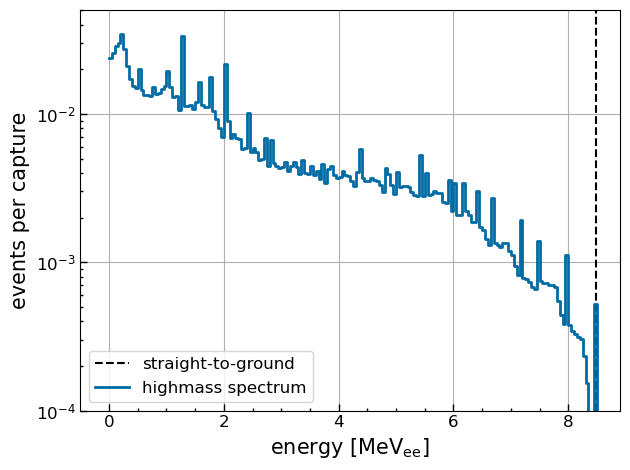

In [14]:
plt.style.use('tableau-colorblind10')
plt.style.use('../figures/style.mplstyle')

plt.figure()
plt.grid()
plt.semilogy()

if 0:
    for det in ('highmass1', 'highmass2'):
        plt.step(cts.Ebins, cts.cts[det]/cts.Nprimaries, where = 'post', label = det)

plt.axvline(E1, linestyle = 'dashed', color = 'k', label = 'straight-to-ground', linewidth = 1.5)
plt.step(cts.Ebins, cts.hm/cts.Nprimaries, where = 'post', label = 'highmass spectrum')


#plt.plot([E1], [cts.hm[idx_E1]/cts.Nprimaries], '*', label = 'straight-to-ground')
plt.legend()
wind = plt.axis()
plt.axis((wind[0], 8.9, 1e-4, wind[3]))

#plt.title('postcapture event spectrum')
plt.xlabel(r'energy [MeV$_\text{ee}$]')
plt.ylabel('events per capture')
plt.tight_layout()
plt.savefig('../figures/sim_capture_gamma_spectrum.pdf')

Text(0, 0.5, 'events per capture')

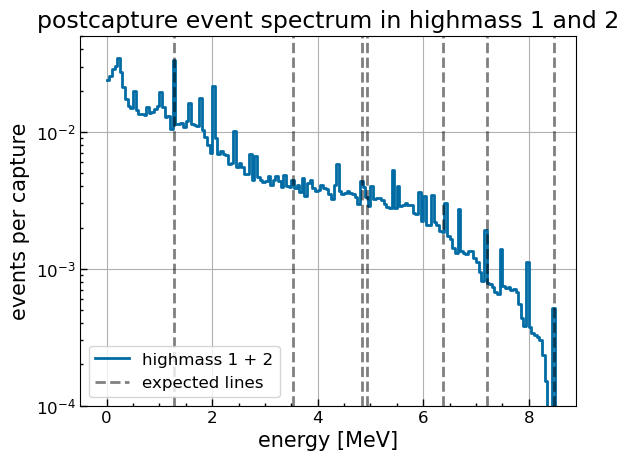

In [12]:

lines, heights = np.array([
    [4.9344, 62.6],
    [4.8403, 10.7],
    [8.4736, 2.1],
    [8.4736 - 1.2734, 6.8],
    [6.3806, 4],
    [8.4736 - 4.9344, 62.6 + 3.9],
    [1.2734, 6.8 + 3.9]
]).T

plt.figure()
plt.grid()
plt.semilogy()

plt.step(cts.Ebins, cts.hm/cts.Nprimaries, where = 'post', label = 'highmass 1 + 2')

#plt.axvline(E1, linestyle = 'dashed', color = 'gray', label = 'straight-to-ground')
#plt.plot([E1], [cts.hm[idx_E1]/cts.Nprimaries], '*', label = 'straight-to-ground')
plt.legend()
wind = plt.axis()
plt.axis((wind[0], 8.9, 1e-4, wind[3]))

for line in lines:
    linekwargs = {'linestyle': 'dashed', 'alpha': 0.5, 'color': 'k'}
    if line == lines[0]:
        plt.axvline(line, label = 'expected lines', **linekwargs)
    else:
        plt.axvline(line, linestyle = 'dashed', color = 'k', alpha = 0.5)


#plt.plot(lines, heights*cts.hm[idx_E1]/cts.Nprimaries/2.1, '+', label = 'expected line positions')

plt.legend()
plt.title('postcapture event spectrum in highmass 1 and 2')
plt.xlabel('energy [MeV]')
plt.ylabel('events per capture')

In [9]:
cts.cts['highmass1'][idx_E1], cts.cts['highmass2'][idx_E1]

(26068.0, 25922.0)

In [10]:
1/np.sqrt(cts.cts['highmass1'][idx_E1])

0.0061936426394580005

In [11]:
# (26068.0, 25922.0) before using yield